# Usando Weak Supervision para rotular um dataset com consultas bancárias online

## Dataset
o dataset [banking77](https://huggingface.co/datasets/PolyAI/banking77) é um conjunto de dados composto por consultas bancárias on-line anotadas com suas intenções correspondentes. 

Encontrei esse dataset através do artigo [Stronger Than You Think: Benchmarking Weak Supervision on Realistic Tasks](https://arxiv.org/pdf/2501.07727) que traz a perrogativa que os benchmarks de weak supervision precisam de datasets que transmitam a complexidade de situações reais. No artigos os autores usam varios dataset para cria um novo benchmark mostrando o real poder da weak supervision. 

Por ser um dataset usando para a crianção desse benchmark, utilizarei ele para fazer o trabalho afim de chega proximo do resultado obtido no artigo.

## carregando dataset

In [293]:
import os
import pandas as pd
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset

load_dotenv()

DATA_DIR = "data"
TRAIN_CSV = os.path.join(DATA_DIR, "banking77_train.csv")
TEST_CSV = os.path.join(DATA_DIR, "banking77_test.csv")

hf_token = os.getenv("HF_TOKEN")

if not hf_token:
    raise ValueError("Token HF_TOKEN não encontrado no .env")


In [294]:
def download_and_save_dataset(token):
    print("Baixando dataset do Hugging Face...")

    login(token=token)
    dataset = load_dataset("PolyAI/banking77")
    print(dataset)

    os.makedirs(DATA_DIR, exist_ok=True)

    dataset["train"].to_csv(TRAIN_CSV, index=False)
    dataset["test"].to_csv(TEST_CSV, index=False)

    print("Dataset salvo em CSV.")
    return dataset

def load_csv_with_labels():
    print("Carregando CSVs salvos...")
    train_df = pd.read_csv(TRAIN_CSV)
    test_df = pd.read_csv(TEST_CSV)
    return train_df, test_df

def add_label_names(df, label_names):
    df["label_name"] = df["label"].apply(lambda i: label_names[i])
    return df


In [295]:
if os.path.exists(TRAIN_CSV) and os.path.exists(TEST_CSV):
    train_df, test_df = load_csv_with_labels()

    dataset = load_dataset("PolyAI/banking77", split="train", download_mode="reuse_dataset_if_exists")
    label_names = dataset.features["label"].names

    train_df = add_label_names(train_df, label_names)
    test_df = add_label_names(test_df, label_names)
else:
    dataset = download_and_save_dataset(hf_token)
    train_df = dataset["train"].to_pandas()
    test_df = dataset["test"].to_pandas()

    label_names = dataset["train"].features["label"].names
    train_df = add_label_names(train_df, label_names)
    test_df = add_label_names(test_df, label_names)

print("Amostra do conjunto de treino:")
display(train_df.head())

print("\nAmostra do conjunto de teste:")
display(test_df.head())


Carregando CSVs salvos...
Amostra do conjunto de treino:


,text,label,label_name
0,I am still waiting on my card?,11,card_arrival
1,What can I do if my card still hasn't arrived ...,11,card_arrival
2,I have been waiting over a week. Is the card s...,11,card_arrival
3,Can I track my card while it is in the process...,11,card_arrival
4,"How do I know if I will get my card, or if it ...",11,card_arrival



Amostra do conjunto de teste:


,text,label,label_name
0,How do I locate my card?,11,card_arrival
1,"I still have not received my new card, I order...",11,card_arrival
2,I ordered a card but it has not arrived. Help ...,11,card_arrival
3,Is there a way to know when my card will arrive?,11,card_arrival
4,My card has not arrived yet.,11,card_arrival


# Análise exploratória

#### Número de amostras em treino e teste

In [ ]:
print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

Train samples: 10003
Test samples: 3080


In [297]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10003 entries, 0 to 10002
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        10003 non-null  object
 1   label       10003 non-null  int64 
 2   label_name  10003 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.6+ KB
None


In [298]:
train_df.isnull().sum()

text          0
label         0
label_name    0
dtype: int64

In [299]:
train_df.nunique()

text          10003
label            77
label_name       77
dtype: int64

In [300]:
train_df.duplicated().sum()

0

In [301]:
len(train_df['label_name'].unique())

77

In [302]:
print(train_df['label_name'].unique())

['card_arrival' 'card_linking' 'exchange_rate'
 'card_payment_wrong_exchange_rate' 'extra_charge_on_statement'
 'pending_cash_withdrawal' 'fiat_currency_support'
 'card_delivery_estimate' 'automatic_top_up' 'card_not_working'
 'exchange_via_app' 'lost_or_stolen_card' 'age_limit' 'pin_blocked'
 'contactless_not_working' 'top_up_by_bank_transfer_charge'
 'pending_top_up' 'cancel_transfer' 'top_up_limits'
 'wrong_amount_of_cash_received' 'card_payment_fee_charged'
 'transfer_not_received_by_recipient' 'supported_cards_and_currencies'
 'getting_virtual_card' 'card_acceptance' 'top_up_reverted'
 'balance_not_updated_after_cheque_or_cash_deposit'
 'card_payment_not_recognised' 'edit_personal_details'
 'why_verify_identity' 'unable_to_verify_identity' 'get_physical_card'
 'visa_or_mastercard' 'topping_up_by_card' 'disposable_card_limits'
 'compromised_card' 'atm_support' 'direct_debit_payment_not_recognised'
 'passcode_forgotten' 'declined_cash_withdrawal' 'pending_card_payment'
 'lost_or_sto

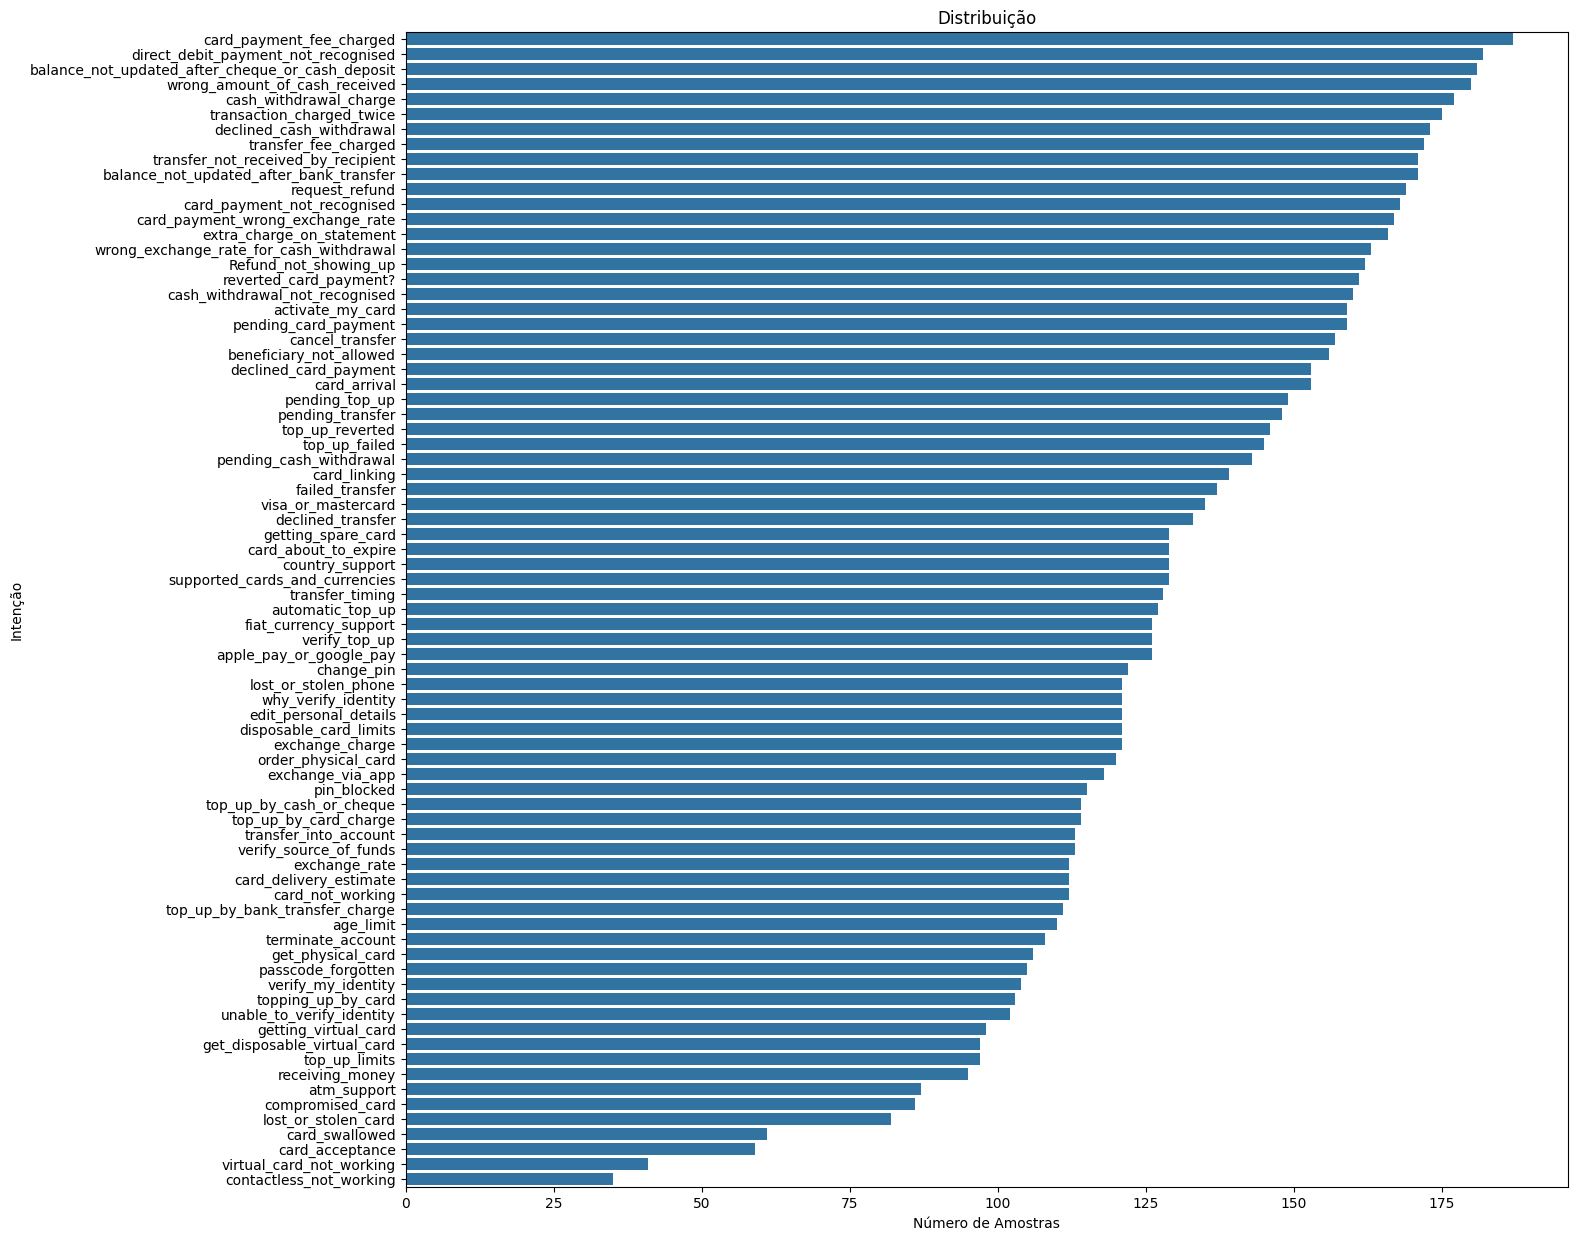

In [303]:
import matplotlib.pyplot as plt
import seaborn as sns

# Contagem por label_name 
plt.figure(figsize=(15,15))
sns.countplot(data=train_df, y="label_name", order=train_df["label_name"].value_counts().index)
plt.title("Distribuição")
plt.xlabel("Número de Amostras")
plt.ylabel("Intenção")
plt.show()


count    10003.000000
mean        11.949415
std          7.891577
min          2.000000
25%          7.000000
50%         10.000000
75%         13.000000
max         79.000000
Name: text_len, dtype: float64


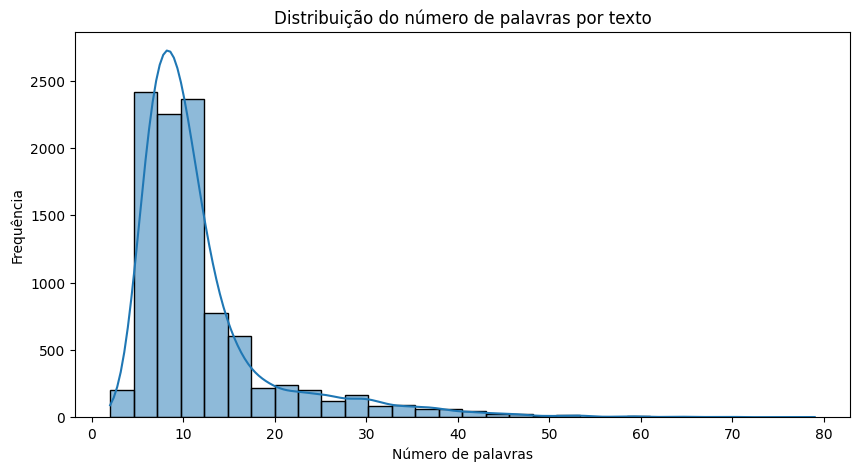

In [304]:
train_df['text_len'] = train_df['text'].apply(lambda x: len(x.split()))

print(train_df['text_len'].describe())

# Histograma do comprimento dos textos
plt.figure(figsize=(10,5))
sns.histplot(train_df['text_len'], bins=30, kde=True)
plt.title("Distribuição do número de palavras por texto")
plt.xlabel("Número de palavras")
plt.ylabel("Frequência")
plt.show()


,train,test
label_name,,
Refund_not_showing_up,162,40
activate_my_card,159,40
age_limit,110,40
apple_pay_or_google_pay,126,40
atm_support,87,40
...,...,...
virtual_card_not_working,41,40
visa_or_mastercard,135,40
why_verify_identity,121,40


<Axes: title={'center': 'Comparação de frequência das intenções (treino vs teste)'}, xlabel='label_name'>

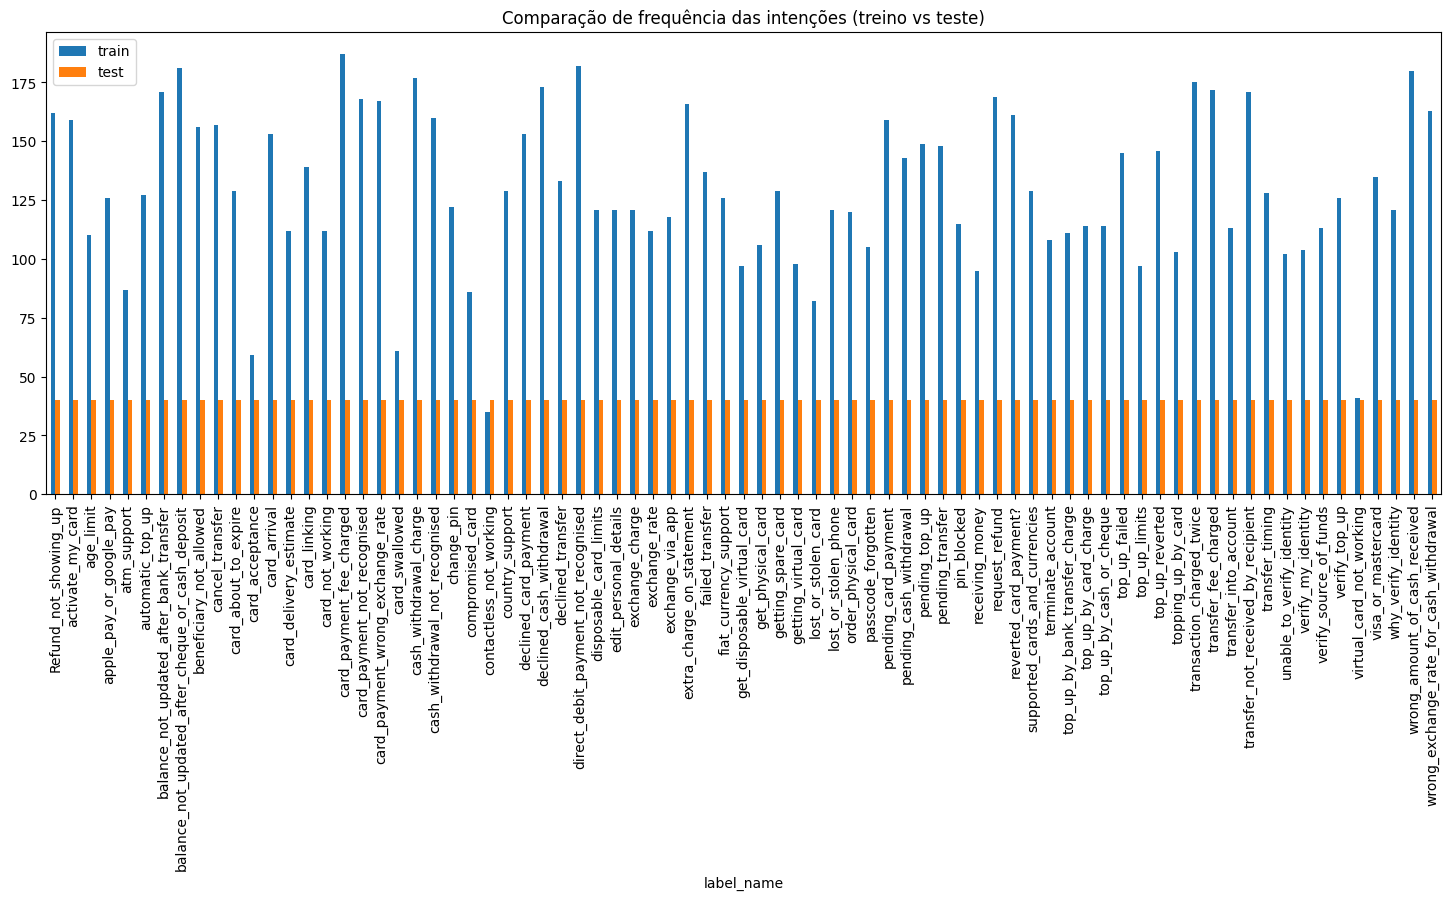

In [305]:
train_counts = train_df['label_name'].value_counts().sort_index()
test_counts = test_df['label_name'].value_counts().sort_index()

balance_df = pd.DataFrame({'train': train_counts, 'test': test_counts})

display(balance_df)

balance_df.plot(kind='bar', figsize=(18,6), title="Comparação de frequência das intenções (treino vs teste)")


percebe-se que os dados de treino estão com uma distribuição mais proximo da vida real, todos desbalanceados, enquanto o dados de teste bem balanceados.

## Limpeza

Removendo acentos, pontuações, espaços execessivos, e letras repetidas. Não foi removido stopwords, pois elas podem fazer diferença na hora da inferência dos modelos.

In [307]:
print(train_df.shape)

(10003, 4)


In [ ]:
import re
import unicodedata
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

def to_lowercase(texts):
    return np.array([text.lower() for text in texts])

def remove_accented_characters(texts):
    return np.array([
        unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        for text in texts
    ])

def remove_punctuation_numbers(texts):
    return np.array([re.sub(r"[^\w\s]", "", re.sub(r"\d+", "", text)) for text in texts])

def remove_excessive_spaces(texts):
    return np.array([re.sub(r"\s+", " ", text).strip() for text in texts])

def remove_repeated_letters(texts):
    return np.array([re.sub(r"(.)\1{2,}", r"\1", text) for text in texts])

# Criar a pipeline
pipeline_clean_text = Pipeline([
    ("to_lowercase", FunctionTransformer(to_lowercase)),
    ("remove_accented_characters", FunctionTransformer(remove_accented_characters)),
    ("remove_punctuation_numbers", FunctionTransformer(remove_punctuation_numbers)),
    ("remove_excessive_spaces", FunctionTransformer(remove_excessive_spaces)),
    ("remove_repeated_letters", FunctionTransformer(remove_repeated_letters)),
])

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [309]:
train_df["text"] = pipeline_clean_text.transform(train_df["text"].values)

train_df["text"].head(10)

0                        i am still waiting on my card
1    what can i do if my card still hasnt arrived a...
2    i have been waiting over a week is the card st...
3    can i track my card while it is in the process...
4    how do i know if i will get my card or if it i...
5                     when did you send me my new card
6          do you have info about the card on delivery
7    what do i do if i still have not received my n...
8          does the package with my card have tracking
9             i ordered my card but it still isnt here
Name: text, dtype: object

In [310]:
train_df["text"].str.len().describe([0.05, 0.1, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.98, 0.99, 0.999])

count    10003.000000
mean        57.710087
std         39.712058
min         12.000000
5%          25.000000
10%         28.000000
25%         35.000000
50%         46.000000
75%         62.000000
80%         69.000000
90%        106.000000
95%        146.000000
98%        185.000000
99%        214.960000
99.9%      322.998000
max        412.000000
Name: text, dtype: float64

In [311]:
test_df["text"] = pipeline_clean_text.transform(test_df["text"].values)

test_df["text"].head(10)

0                              how do i locate my card
1    i still have not received my new card i ordere...
2    i ordered a card but it has not arrived help p...
3      is there a way to know when my card will arrive
4                          my card has not arrived yet
5                              when will i get my card
6    do you know if there is a tracking number for ...
7                          i have not received my card
8                           still waiting on that card
9    is it normal to have to wait over a week for m...
Name: text, dtype: object

## Removendo outliers 

In [ ]:

quantiles = train_df["text"].str.len().quantile([0.02, 0.98]).values

train_df = train_df[train_df["text"].str.len() > quantiles[0]]

train_df = train_df[train_df["text"].str.len() <= quantiles[1]]

print(quantiles)
print(train_df.shape)

[ 21. 185.]
(9601, 4)


wordcloud apenas para ter uma noção geral das palavras no dataset

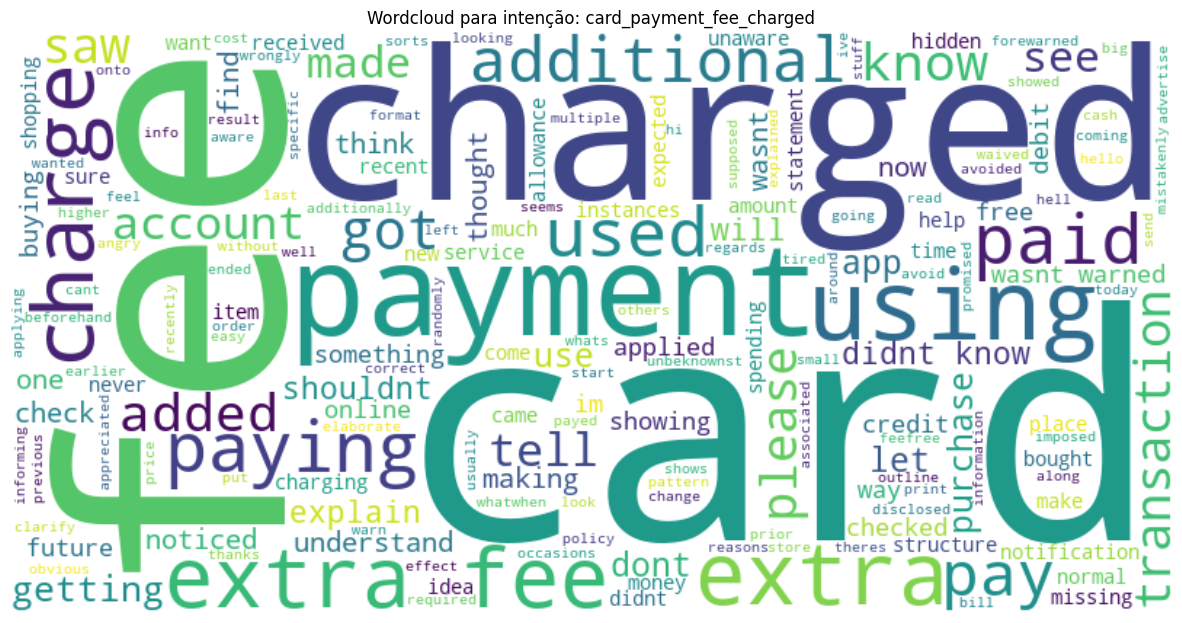

In [ ]:
from wordcloud import WordCloud

plt.figure(figsize=(15,8))
most_common_label = train_df['label_name'].value_counts().index[0]
text = " ".join(train_df[train_df['label_name'] == most_common_label]['text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f"Wordcloud para intenção: {most_common_label}")
plt.show()

### tirando labels

removendo as coluna do dataset de trainamento, pois em um cenario da vida real não teriamos acesso aos rotulos verdadeiros

In [314]:
train_df.columns

Index(['text', 'label', 'label_name', 'text_len'], dtype='object')

In [315]:
train_df_label_name = train_df["label_name"]
train_df_label = train_df["label"]
train_df = train_df.drop(columns=["text_len","label","label_name"])

## Resumno do dataset

- dataset de treino apois limpeza dos dados ficou com ```9601``` linhas
- possui ```77``` categorias
- o tamanho dos texto estão em ```11```  palavras em média 
- não possuem dados duplicados
- não possuem dados nulos
- os dados entre as categorias não estão balanceados, mas é essa justamente a proposta do dataset

# Labeling Function

## Criando palavras chaves

a crianção das palavras chaves foi feita empiricamente observando o dataset e o sentido atribuido a cada label. também usei como base algumas palavras chaves que são citadas no artigo. 

Adicionei variações de palavras, como colocar no passado, gerundio, plural, para ter uma maior codertura com os rotulos. 

In [316]:
label_keywords = {
    "activate_my_card": ["activate","activation","activated", "activating"],
    "age_limit": ["age", "limit", "restriction", "requirement"],
    "apple_pay_or_google_pay": ["apple pay", "apple watch","google pay", "mobile payment", "wallet", "pay"],
    "atm_support": ["atm","atms", "support", "cash withdrawal", "machine"],
    "automatic_top_up": ["automatic", "top up", "auto", "funds", "recharge","automatically"],
    "balance_not_updated_after_bank_transfer": ["balance", "not updated", "bank transfer", "not", "pending","bank"],
    "balance_not_updated_after_cheque_or_cash_deposit": ["balance", "not updated", "cheque", "cash deposit", "pending","deposit","deposited"],
    "beneficiary_not_allowed": ["beneficiary", "not allowed", "transfer", "restriction"],
    "cancel_transfer": ["cancel", "transfer", "stop", "abort", "revoke","mistake"],
    "card_about_to_expire": ["expiry", "about", "soon","expire","expired","expires"],
    "card_acceptance": ["acceptance", "accepted", "merchant", "declined"],
    "card_arrival": ["arrived", "delivery", "shipping","received","ordered","waiting","card"],
    "card_delivery_estimate": ["delivery", "soon", "arrive", "time","delivered"],
    "card_linking": ["linking", "connect", "associate","reactivate","lost"],
    "card_not_working": ["not working", "malfunction", "issue", "problem","anymore","not work", "card"],
    "card_payment_fee_charged": ["payment", "fee", "charged", "cost","charge","payments","paid", "card"],
    "card_payment_not_recognised": ["payment not ", "not recognised", "unknown", "unauthorized","recognize", "card"],
    "card_payment_wrong_exchange_rate": ["payment wrong", "wrong exchange rate", "incorrect", "rate","exchange", "card"],
    "card_swallowed": ["swallowed", "atm", "machine", "lost","took","card"],
    "cash_withdrawal_charge": ["cash", "withdrawal", "charge", "fee", "cost","withdrawing","card"],
    "cash_withdrawal_not_recognised": ["cash", "withdrawal not", "not recognised", "unknown", "unauthorized"],
    "change_pin": ["change", "pin", "modify", "update", "password"],
    "compromised_card": ["compromised", "fraud", "stolen", "security","permission"],
    "contactless_not_working": ["contactless", "not working", "issue", "problem", "payment"],
    "country_support": ["country", "support", "available", "region", "location","countries"],
    "declined_card_payment": ["declined", "payment", "rejected", "failed"],
    "declined_cash_withdrawal": ["declined", "cash withdrawal", "rejected", "failed"],
    "declined_transfer": ["declined", "transfer", "rejected", "failed","decline"],
    "direct_debit_payment_not_recognised": ["direct debit", "payment", "not recognised", "unknown", "unauthorized"],
    "disposable_card_limits": ["disposable", "limits", "restriction","restrictions"],
    "edit_personal_details": ["edit", "personal details", "update", "modify", "information","married"],
    "exchange_charge": ["exchange", "charge", "fee", "cost","exchanges","exchanging"],
    "exchange_rate": ["exchange", "rate", "currency", "conversion","rates"],
    "exchange_via_app": ["exchange", "app", "mobile", "application", "convert"],
    "extra_charge_on_statement": ["extra", "charge", "statement", "fee", "unexpected","charged"],
    "failed_transfer": ["failed", "transfer", "error", "unsuccessful", "issue"],
    "fiat_currency_support": ["fiat", "currency", "support", "available", "type","currencies"],
    "get_disposable_virtual_card": ["get", "disposable", "virtual", "obtain"],
    "get_physical_card": ["get", "physical", "obtain", "order","pin"],
    "getting_spare_card": ["getting", "spare", "extra", "additional"],
    "getting_virtual_card": ["getting", "virtual", "obtain", "order"],
    "lost_or_stolen_card": ["lost", "stolen", "missing", "fraud"],
    "lost_or_stolen_phone": ["lost", "stolen", "phone", "mobile", "missing"],
    "order_physical_card": ["order", "physical", "request", "purchase","receive"],
    "passcode_forgotten": ["passcode", "forgotten", "reset", "password","code"],
    "pending_card_payment": ["pending", "payment", "processing", "waiting","showing"],
    "pending_cash_withdrawal": ["pending", "cash withdrawal", "processing", "waiting","transaction"],
    "pending_top_up": ["pending", "top up", "waiting"],
    "pending_transfer": ["pending", "transfer", "waiting"],
    "pin_blocked": ["pin", "blocked", "locked", "disabled","entered"],
    "receiving_money": ["receiving", "money", "funds", "incoming"],
    "Refund_not_showing_up": ["refund", "not showing up", "missing", "absent","seller"],
    "request_refund": ["request", "refund", "ask", "demand","refunded"],
    "reverted_card_payment?": ["reverted", "payment", "reversed", "cancelled"],
    "supported_cards_and_currencies": ["supported", "currencies", "available", "types"],
    "terminate_account": ["terminate", "account", "close", "delete","company"],
    "top_up_by_bank_transfer_charge": ["top up", "bank transfer", "charge", "fee","transfers","transfer"],
    "top_up_by_card_charge": ["top up", "card", "charge", "fee"],
    "top_up_by_cash_or_cheque": ["top up", "cash", "cheque", "deposit","check"],
    "top_up_failed": ["top up", "failed", "error", "unsuccessful","declined"],
    "top_up_limits": ["top up", "limits", "restriction","maximum"],
    "top_up_reverted": ["top up", "reverted", "reversed", "cancelled","disappeared"],
    "topping_up_by_card": ["topping up", "card", "funds", "recharge"],
    "transaction_charged_twice": ["transaction", "charged twice", "duplicate", "double","charge"],
    "transfer_fee_charged": ["transfer", "fee", "charged", "cost","transferring"],
    "transfer_into_account": ["transfer", "into account", "deposit", "funds"],
    "transfer_not_received_by_recipient": ["transfer", "not received", "recipient", "missing"],
    "transfer_timing": ["transfer", "timing", "delay", "time","wait"],
    "unable_to_verify_identity": ["unable", "verify identity", "problem", "issue","verifying","verified"],
    "verify_my_identity": ["verify", "identity", "confirm", "authenticate","documents","id","verification"],
    "verify_source_of_funds": ["verify", "source of funds", "confirm", "origin","available"],
    "verify_top_up": ["verify", "top up", "confirm", "authenticate","verification","verified"],
    "virtual_card_not_working": ["virtual card", "not working", "issue", "problem","disposable","rejected"],
    "visa_or_mastercard": ["visa", "mastercard", "card", "type","choose"],
    "why_verify_identity": ["why", "verify identity", "reason", "purpose"],
    "wrong_amount_of_cash_received": ["wrong amount", "cash received", "incorrect", "error","requested"],
    "wrong_exchange_rate_for_cash_withdrawal": ["wrong exchange rate", "cash withdrawal", "incorrect", "rate","applied"]
}
len(label_keywords)

77

### Criando uma LF para cada palavra-chave e associando com sua respectiva Label

a criação das LF se deu por cada palavra-chave ser uma LF associado a sua label

In [317]:
import pandas as pd
import re
from snorkel.labeling import labeling_function, PandasLFApplier

df = train_df.copy()
df["text"] = df["text"].astype(str)

label_to_int = dict(zip(train_df_label_name, train_df_label))
int_to_label = dict(zip(train_df_label, train_df_label_name))
ABSTAIN = -1

# Fábrica de labeling functions
def make_keyword_lf(label_name, keyword, label_id, idx):
    keyword_safe = re.sub(r"\W+", "_", keyword)
    lf_name = f"lf_{label_name}_{keyword_safe}_{idx}"

    @labeling_function(name=lf_name)
    def lf(x):
        return label_id if re.search(re.escape(keyword), x.text, re.IGNORECASE) else ABSTAIN

    return lf

# Criar todas as labeling functions
lfs = []
for label, keywords in label_keywords.items():
    label_id = label_to_int[label]
    for idx, keyword in enumerate(keywords):
        lfs.append(make_keyword_lf(label, keyword, label_id, idx))


# Aplicar as LFs
applier = PandasLFApplier(lfs)
L_train = applier.apply(df)


  0%|          | 0/9601 [00:00<?, ?it/s]

100%|██████████| 9601/9601 [00:16<00:00, 590.22it/s]


#### Treinando com MajorityLabelVoter

utlizando o Majority vote para criar o modelo de rotulagem por se trata de uma técnica simples, poŕem bastante eficaz

In [318]:
from snorkel.labeling.model import MajorityLabelVoter

majority_model = MajorityLabelVoter(cardinality=len(label_names), tie_break_policy="random")

# Prever rótulos fracos
df["weak_label"] = majority_model.predict(L=L_train, tie_break_policy="random")
df["predicted_label_name"] = df["weak_label"].map(int_to_label)

df.to_csv("banking77_with_weak_labels_majorityLabelVoter.csv", index=False)
print(df[["text", "predicted_label_name"]].head())

                                                text predicted_label_name
0                      i am still waiting on my card         card_arrival
1  what can i do if my card still hasnt arrived a...         card_arrival
2  i have been waiting over a week is the card st...         card_arrival
3  can i track my card while it is in the process...         card_arrival
4  how do i know if i will get my card or if it i...       card_swallowed


# METRICAS

In [324]:
df

,text,weak_label,predicted_label_name
0,i am still waiting on my card,11,card_arrival
1,what can i do if my card still hasnt arrived a...,11,card_arrival
2,i have been waiting over a week is the card st...,11,card_arrival
3,can i track my card while it is in the process...,11,card_arrival
4,how do i know if i will get my card or if it i...,18,card_swallowed
...,...,...,...
9998,you provide support in what countries,24,country_support
9999,what countries are you supporting,24,country_support
10000,what countries are getting support,24,country_support
10001,are cards available in the eu,11,card_arrival


In [325]:
df[df['weak_label']==-1].head(10)
df[df['weak_label']==-1].shape[0]

0

In [326]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, matthews_corrcoef, classification_report
from snorkel.labeling import LFAnalysis

df["true_label"] = train_df_label
df["true_label_name"] = train_df_label_name

y_true = df["true_label"]
y_pred = df["weak_label"]

In [327]:
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
print("Matthews Corrcoef:", matthews_corrcoef(y_true, y_pred))

Accuracy: 0.3573586084782835
F1 Score (macro): 0.333606650305964
Recall (macro): 0.36126586177483805
Matthews Corrcoef: 0.35030281898523463


In [328]:
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_names))


Classification Report:

                                                  precision    recall  f1-score   support

                                activate_my_card       0.83      0.19      0.31       155
                                       age_limit       0.43      0.27      0.33       109
                         apple_pay_or_google_pay       0.70      0.68      0.69       126
                                     atm_support       0.33      0.28      0.30        86
                                automatic_top_up       0.68      0.75      0.71       125
         balance_not_updated_after_bank_transfer       0.23      0.22      0.23       170
balance_not_updated_after_cheque_or_cash_deposit       0.78      0.47      0.59       179
                         beneficiary_not_allowed       0.64      0.34      0.45       155
                                 cancel_transfer       0.50      0.47      0.49       150
                            card_about_to_expire       0.72      0.45     

In [ ]:
lf_analysis = LFAnalysis(L=L_train, lfs=lfs)
lf_summary = lf_analysis.lf_summary()
print("\n== Análise das LFs ==")
print(lf_summary.sort_values(by="Polarity", ascending=True))


== Análise das LFs ==
                                                      j Polarity  Coverage  \
lf_pin_blocked_disabled_3                           257       []  0.000000   
lf_transfer_into_account_into_account_1             330       []  0.000000   
lf_transfer_timing_timing_1                         338       []  0.000000   
lf_direct_debit_payment_not_recognised_not_reco...  156       []  0.000000   
lf_country_support_region_3                         138       []  0.000000   
...                                                 ...      ...       ...   
lf_wrong_exchange_rate_for_cash_withdrawal_rate_3   389     [76]  0.041975   
lf_wrong_exchange_rate_for_cash_withdrawal_wron...  386     [76]  0.002500   
lf_wrong_exchange_rate_for_cash_withdrawal_cash...  387     [76]  0.018852   
lf_wrong_exchange_rate_for_cash_withdrawal_inco...  388     [76]  0.006770   
lf_wrong_exchange_rate_for_cash_withdrawal_appl...  390     [76]  0.005624   

                                        

In [330]:
low_coverage_lfs = lf_summary[lf_summary["Coverage"] < 0.01]

print("\n== LFs com baixa cobertura (< 1%) ==")
print(low_coverage_lfs)


== LFs com baixa cobertura (< 1%) ==
                                                      j Polarity  Coverage  \
lf_activate_my_card_activation_1                      1      [0]  0.001666   
lf_activate_my_card_activated_2                       2      [0]  0.001562   
lf_activate_my_card_activating_3                      3      [0]  0.002396   
lf_age_limit_restriction_2                            6      [1]  0.002812   
lf_age_limit_requirement_3                            7      [1]  0.000729   
...                                                 ...      ...       ...   
lf_wrong_amount_of_cash_received_error_3            384     [75]  0.005520   
lf_wrong_amount_of_cash_received_requested_4        385     [75]  0.004895   
lf_wrong_exchange_rate_for_cash_withdrawal_wron...  386     [76]  0.002500   
lf_wrong_exchange_rate_for_cash_withdrawal_inco...  388     [76]  0.006770   
lf_wrong_exchange_rate_for_cash_withdrawal_appl...  390     [76]  0.005624   

                         

Analisando as métricas é perceptivel que não foi obtido um resultado satisfatorio em relação a varios aspectos, como a acuracia e coberturas das LF.

O que pode ser feito para melhorar é utilizar outros label models além do majority vote, melhorar a crição das LF adicionando ou retirando palavras chaves.

Tentei outros model label, porém por causa do numero grande LF, ```391```, o ambiente crashou e não foi encontrado uma solução, e por isso apenas o Majority Voter foi utilizado. 

# Modelos de classificação

#### Modelo com rotulos fracos

modelo Tfidf + Logistic Regression

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

X_train = train_df["text"]
y_train = y_pred
X_test = test_df["text"]
y_test = test_df["label"]

pipeline_tfidf = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=1000, random_state=2505))
])

pipeline_tfidf.fit(X_train, y_train)
y_pred_tfidf = pipeline_tfidf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print("Matthews Corrcoef:", matthews_corrcoef(y_test, y_pred_tfidf))

report_tfidf = classification_report(y_test, y_pred_tfidf, output_dict=True)
report_tfidf_summary = {label: {"precision": metrics["precision"], "recall": metrics["recall"], "f1-score": metrics["f1-score"]}
                        for label, metrics in report_tfidf.items() if label in {"macro avg", "weighted avg"}}

report_tfidf_summary


Accuracy: 0.37012987012987014
Matthews Corrcoef: 0.36553795284796425


/home/vscode/.cache/pypoetry/virtualenvs/my-project-Pi8owkJW-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vscode/.cache/pypoetry/virtualenvs/my-project-Pi8owkJW-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vscode/.cache/pypoetry/virtualenvs/my-project-Pi8owkJW-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

{'macro avg': {'precision': 0.46433135425770233,
  'recall': 0.37012987012987014,
  'f1-score': 0.3401192187731659},
 'weighted avg': {'precision': 0.4643313542577024,
  'recall': 0.37012987012987014,
  'f1-score': 0.34011921877316603}}

#### Modelo com o rotulo forte

In [335]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

X_train = train_df["text"]
y_train = train_df_label
X_test = test_df["text"]
y_test = test_df["label"]

pipeline_tfidf = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=1000, random_state=2505))
])

pipeline_tfidf.fit(X_train, y_train)
y_pred_tfidf = pipeline_tfidf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print("Matthews Corrcoef:", matthews_corrcoef(y_test, y_pred_tfidf))

report_tfidf = classification_report(y_test, y_pred_tfidf, output_dict=True)
report_tfidf_summary = {label: {"precision": metrics["precision"], "recall": metrics["recall"], "f1-score": metrics["f1-score"]}
                        for label, metrics in report_tfidf.items() if label in {"macro avg", "weighted avg"}}

report_tfidf_summary

Accuracy: 0.8694805194805195
Matthews Corrcoef: 0.8678796776734913


{'macro avg': {'precision': 0.8786468460853573,
  'recall': 0.8694805194805195,
  'f1-score': 0.869400142419153},
 'weighted avg': {'precision': 0.8786468460853575,
  'recall': 0.8694805194805195,
  'f1-score': 0.869400142419153}}

O modelo com o rotulo fraco conseguiu uma acuracia de 86%, enquando o modelo com os rotulos fracos uma acuracia de 37%, oque era esperado ja que os rotulos que foram usados para treina o modelo não tinha uma boa cobertura.

# Teste com modelos LLM zero-shot

## Gemini

In [ ]:
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage
from tqdm import tqdm

In [281]:
load_dotenv()
df_test_gemini = test_df[0:900] 

In [276]:
def construir_prompt(text):
    return [
        SystemMessage(content=(
            "You are an expert in banking financial service domain, and you are good at classification."
        )),
        HumanMessage(content=(
            f"Classify the following text into one of the categories: {int_to_label}. Text: {text}, Respond only with the label number (e.g., 0, 1, 2...). Do not explain. Do not output any text other than the number."
        ))
    ]

In [282]:
import time

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-lite", temperature=0)

labels = []
for text in tqdm(df_test_gemini["text"], desc="Classificando"):
    messages = construir_prompt(text)
    response = llm.invoke(messages).content.strip()

    if response.isdigit():
        labels.append(int(response))
    else:
        print(f"Aviso: resposta inesperada → '{response}'")
        labels.append(None)

    time.sleep(2.1) 

df_test_gemini["generate_label"] = labels
df_test_gemini.to_csv("data/banking77_gemini_label.csv", index=False)
print(df_test_gemini)

Classificando: 100%|██████████| 900/900 [39:15<00:00,  2.62s/it]

                                                  text  label  \
0                              how do i locate my card     11   
1    i still have not received my new card i ordere...     11   
2    i ordered a card but it has not arrived help p...     11   
3      is there a way to know when my card will arrive     11   
4                          my card has not arrived yet     11   
..                                                 ...    ...   
895  which cards do you guys support i want to top ...     54   
896                    what credit cards are supported     54   
897           what cards and currencies do you support     54   
898  how do i transfer funds from my american expre...     54   
899  how can i use american express to add money to...     54   

                         label_name  generate_label  
0                      card_arrival              41  
1                      card_arrival              11  
2                      card_arrival              11  
3  


/tmp/ipykernel_628/1106361199.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gemini["generate_label"] = labels


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, matthews_corrcoef, classification_report

print("Accuracy:", accuracy_score(df_test_gemini['label'], df_test_gemini['generate_label']))
print("F1 Score (macro):", f1_score(df_test_gemini['label'], df_test_gemini['generate_label'], average='macro'))
print("Recall (macro):", recall_score(df_test_gemini['label'], df_test_gemini['generate_label'], average='macro'))
print("Matthews Corrcoef:", matthews_corrcoef(df_test_gemini['label'], df_test_gemini['generate_label']))

Accuracy: 0.7633333333333333
F1 Score (macro): 0.36519744395836556
Recall (macro): 0.34950000000000003
Matthews Corrcoef: 0.7556614900316583


/home/vscode/.cache/pypoetry/virtualenvs/my-project-Pi8owkJW-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Por limitações da API do gemini, o dataset de test foi reduzido para 900 amostras.

O resultado com usando o modelo gemini-2.0-flash-lite zero-shot foi satisfatorio, se lavamos em conta a quantidade de label e suas proximidades em assuntos, porém muito custoso.

# Conclusões

### Label model

o modelo de supervisão fraca pode ser melhorado, assim como as LF que foram usadas para gera o modelo. 

### Classificação com rotulos fracos

como o modelo de classificação é totalmente dependente dos rotulos, o fato dos rotulos fracos não estarem com uma boa qualidade torna o modelo de classificação ruim.

### Classificação com rotulos fortes

Com os rotulos forte (rotulos que em um caso real de supervisão fracos não teriamos acesso), o modelo de classificação se saiu bem, podendo ser melhorado.

### Classificação usando LLM

Com o Gemini-2.0-flash-lite foi obtido uma boa classificação levando em consideração que foi uma tentativa zero-shot e com pouco contexto disponivel. Pórem ainda é uma solução cara e não escalavel com confiança.  